## Make My Own Regression Model

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import xlrd
from sklearn import linear_model
from sklearn import preprocessing
import statsmodels.formula.api as smf
import scipy.stats as stats
from sklearn import preprocessing


%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

plt.rcParams['figure.figsize'] = [20.0, 7.0]
plt.rcParams.update({'font.size': 22})

sns.set_palette('bright')
sns.set_style('whitegrid')
sns.set_context('talk')

In [2]:
df = pd.read_excel('table_8_offenses_known_to_law_enforcement_new_york_by_city_2013.xls', header=4, skipfooter=3)

In [3]:
print(df.shape)

## sample returns random sample of rows!
df.sample(10)

(348, 13)


,City,Population,Violent crime,Murder and nonnegligent manslaughter,Rape (revised definition)1,Rape (legacy definition)2,Robbery,Aggravated assault,Property crime,Burglary,Larceny- theft,Motor vehicle theft,Arson3
318,Tupper Lake Village,3642,3,0,nan,0,0,3,83,22,59,2,nan
131,Greenwood Lake Village,3118,2,0,nan,0,0,2,21,3,16,2,nan
13,Attica Village,2522,2,0,nan,0,0,2,5,0,4,1,0.000
248,Pelham Village,6982,7,0,nan,1,2,4,172,22,149,1,nan
267,Ramapo Town,87204,57,2,nan,5,9,41,567,88,466,13,nan
17,Ballston Spa Village,5418,8,0,nan,0,3,5,94,16,78,0,1.000
330,Watertown,28179,109,0,nan,12,16,81,1165,169,953,43,nan
217,New York Mills Village,3324,2,0,nan,0,0,2,64,16,47,1,0.000
72,Deerpark Town,7827,7,0,nan,2,2,3,152,52,100,0,nan
218,Niagara Falls,49574,584,3,nan,12,166,403,2807,746,1949,112,22.000


In [4]:
df.columns

Index(['City', 'Population', 'Violent\ncrime',
       'Murder and\nnonnegligent\nmanslaughter',
       'Rape\n(revised\ndefinition)1', 'Rape\n(legacy\ndefinition)2',
       'Robbery', 'Aggravated\nassault', 'Property\ncrime', 'Burglary',
       'Larceny-\ntheft', 'Motor\nvehicle\ntheft', 'Arson3'],
      dtype='object')

In [5]:
#fixing column names
df = df.rename(columns={'Violent\ncrime':'Violent_Crime',
           'Murder and\nnonnegligent\nmanslaughter':'Murder',
           'Rape\n(revised\ndefinition)1':'Rape_Revised',
           'Rape\n(legacy\ndefinition)2':'Rape_Legacy',
           'Aggravated\nassault':'Agg_Assault',
           'Property\ncrime':'Property_Crime',
           'Larceny-\ntheft':'Larceny',
           'Motor\nvehicle\ntheft':'Motor_Vehicle_Theft',
           'Arson3':'Arson'             
          })

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 348 entries, 0 to 347
Data columns (total 13 columns):
City                   348 non-null object
Population             348 non-null int64
Violent_Crime          348 non-null int64
Murder                 348 non-null int64
Rape_Revised           0 non-null float64
Rape_Legacy            348 non-null int64
Robbery                348 non-null int64
Agg_Assault            348 non-null int64
Property_Crime         348 non-null int64
Burglary               348 non-null int64
Larceny                348 non-null int64
Motor_Vehicle_Theft    348 non-null int64
Arson                  187 non-null float64
dtypes: float64(2), int64(10), object(1)
memory usage: 35.4+ KB


In [7]:
# from https://github.com/WillKoehrsen/machine-learning-project-walkthrough/blob/master/Machine%20Learning%20Project%20Part%201.ipynb
# Function to calculate missing values by column# Funct 
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns
missing_values_table(df)

Your selected dataframe has 13 columns.
There are 2 columns that have missing values.


,Missing Values,% of Total Values
Rape_Revised,348,100.000
Arson,161,46.300


In [8]:
#100% of Rape_Revised column is null so dropping column
df=df.drop('Rape_Revised', 1)

In [9]:
df.describe()

,Population,Violent_Crime,Murder,Rape_Legacy,Robbery,Agg_Assault,Property_Crime,Burglary,Larceny,Motor_Vehicle_Theft,Arson
count,348.000,348.000,348.000,348.000,348.000,348.000,348.000,348.000,348.000,348.000,187.000
mean,40037.632,201.595,1.566,5.865,72.902,121.261,792.606,119.684,637.017,35.905,1.872
std,450037.368,2815.269,18.304,60.425,1031.033,1706.132,7659.725,924.949,6346.054,403.424,10.693
min,526.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,3003.000,2.000,0.000,0.000,0.000,1.000,40.500,6.000,31.000,0.000,0.000
50%,7233.500,6.000,0.000,0.000,1.000,4.000,112.500,17.500,94.000,2.000,0.000
75%,18427.500,22.000,0.000,2.000,5.000,14.000,341.000,51.250,287.250,7.000,1.000
max,8396126.000,52384.000,335.000,1112.000,19170.000,31767.000,141971.000,16606.000,117931.000,7434.000,132.000


In [10]:
##not helpful here but

# Print the value counts for categorical columns
#for col in df.columns:
#    if df[col].dtype == 'object':
#        print('\nColumn Name:', col,)
#       print(df[col].value_counts())

In [11]:
#begin eda by focusing on single varible - property crime - because this is the target

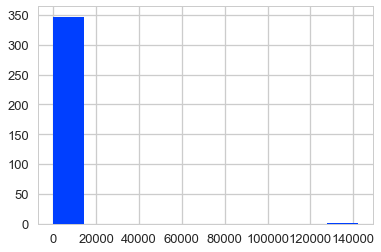

In [12]:
plt.hist(df.Property_Crime);
#ok that's not super helpful...

In [13]:
#normalizing dataframe
def normalize(df):
    normalized_df = df.copy()
    for feature_name in df.columns:
        if df[feature_name].dtype == 'object':
            normalized_df[feature_name] = df[feature_name]
        else:
            max_value = df[feature_name].max()
            min_value = df[feature_name].min()
            normalized_df[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return normalized_df

In [14]:
normal_df = df.drop(columns = ['City', 'Robbery', 'Murder','Arson']).copy()


normal_df = normalize(normal_df)
normal_df.head()

,Population,Violent_Crime,Rape_Legacy,Agg_Assault,Property_Crime,Burglary,Larceny,Motor_Vehicle_Theft
0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
3,0.012,0.015,0.027,0.017,0.029,0.042,0.027,0.019
4,0.001,0.000,0.003,0.001,0.002,0.003,0.001,0.001


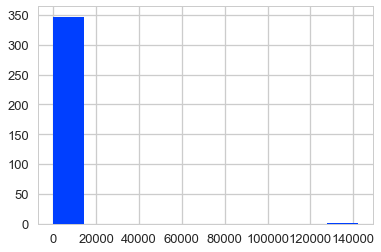

In [15]:
#trying histogram again...still looks the same..
plt.hist(df.Property_Crime);

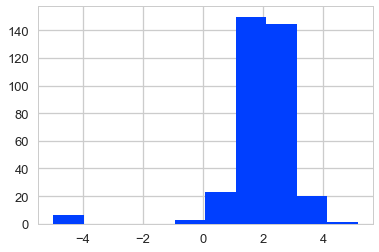

In [16]:
#since skewed to the left trying a log transformation

#apparently there are zero's in the column so replacing them with a really small number
df = df.replace(0, 0.00001)


log_property_crime = np.log10(df.Property_Crime)
plt.hist(log_property_crime);
#yay that looks much better!

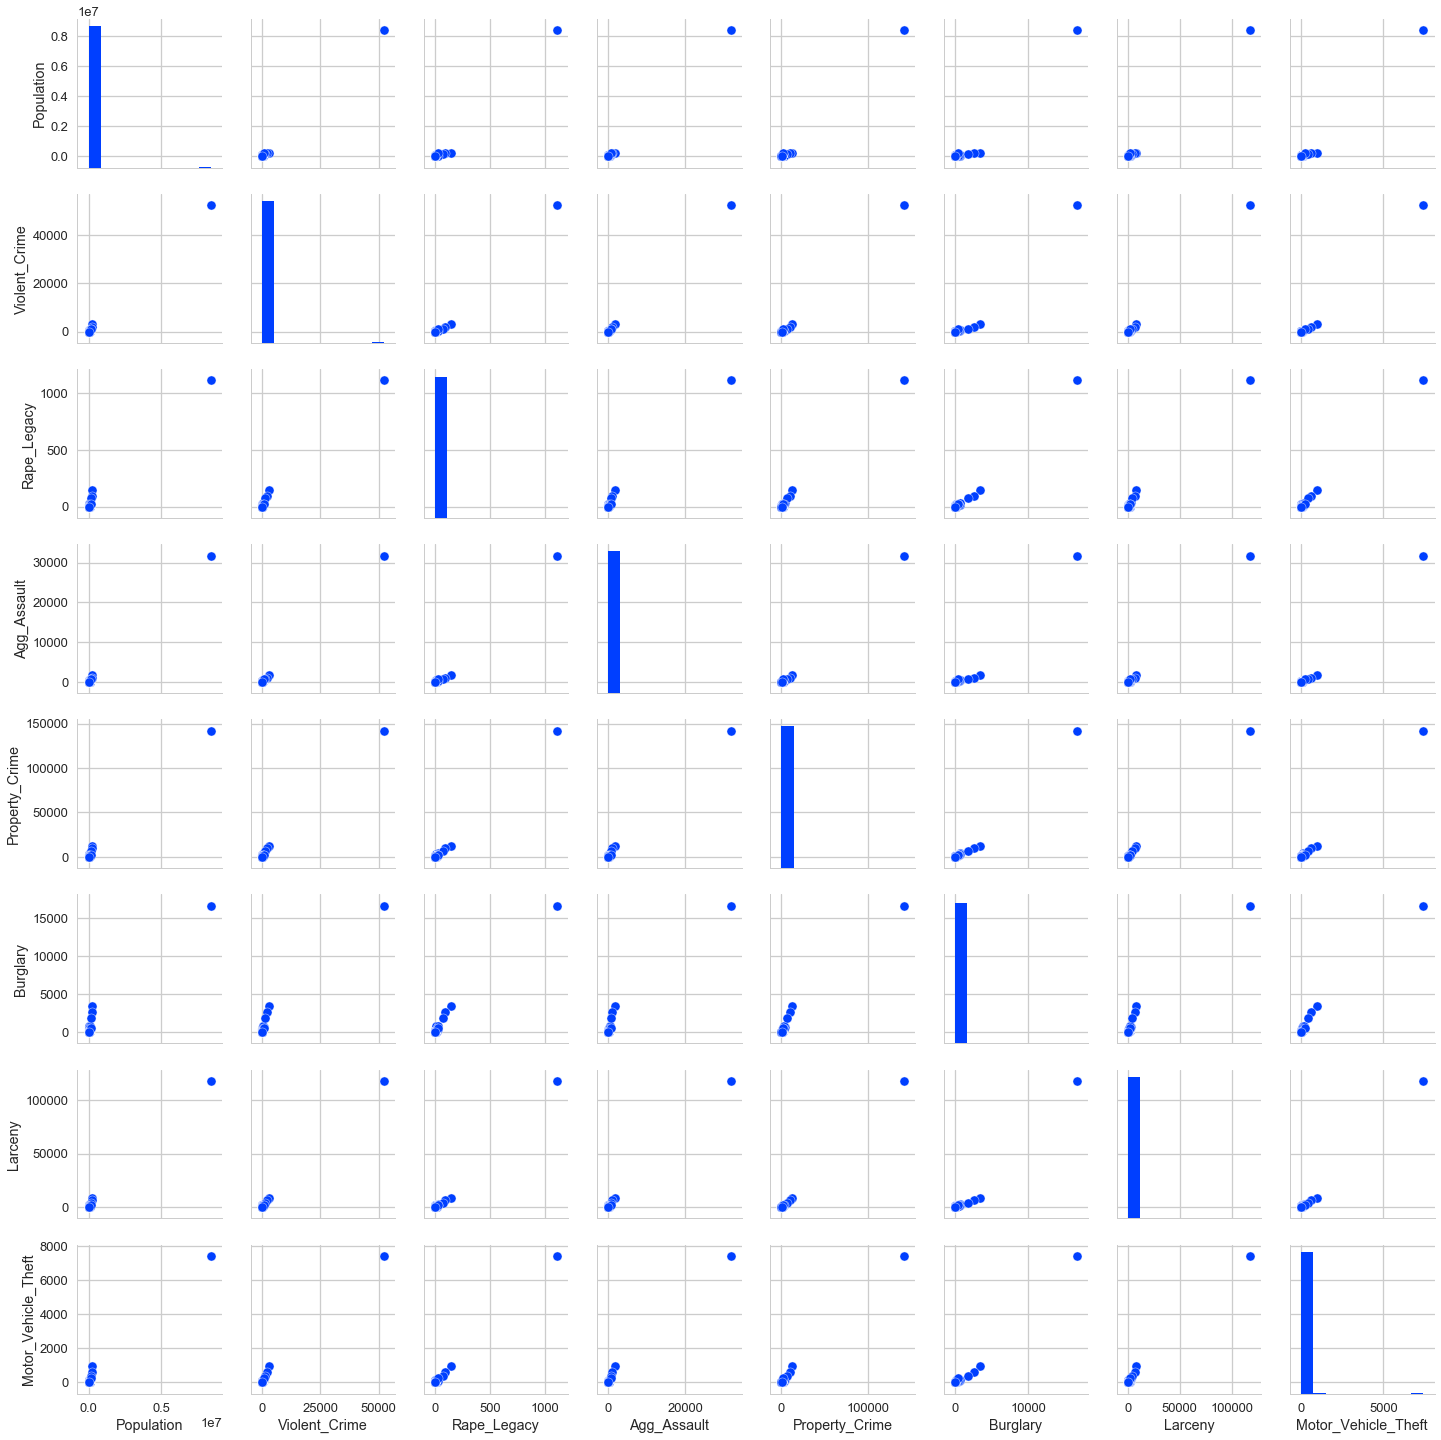

In [17]:
#now lets look at the rest of the dataframe too
plot_data = df.drop(columns = ['City', 'Robbery', 'Murder','Arson']).copy()
plot_data = plot_data.dropna()
sns.pairplot(plot_data);

In [18]:
def logging(df):   
    log_df = df.copy()
    for feature_name in df.columns:
        if df[feature_name].dtype == 'object':
            log_df[feature_name] = df[feature_name]
        else:
            #df = df[feature_name].replace(0, 0.00001)
            log_df[feature_name] = np.log10(df[feature_name])     
    return log_df

In [19]:
log_df = df.drop(columns = ['City', 'Robbery', 'Murder','Arson']).copy()
log_df['Population2'] = df.Population ** 2

log_df = logging(log_df)

In [20]:
#all histograms skewed to left - trying log transformation to try to get more normal distribution
#now lets look at the rest of the dataframe too

#don't want to appl log to Murder and Robbery
#Arson =46% nan so dropping column
log_df = df.drop(columns = ['City', 'Robbery', 'Murder','Arson']).copy()
log_df['Population2'] = df.Population ** 2

log_df = logging(log_df)

#adding Muder and Robbery back and converting to categorical
log_df['Murder'] = df.Murder
log_df['Murder'] = np.where(log_df.Murder >= 1, 1, 0)
log_df['Murder'] = log_df.Murder.astype('category')

log_df['Burglary'] = df.Burglary
log_df['Burglary'] = np.where(log_df.Burglary >= 1, 1, 0)
log_df['Burglary'] = log_df.Burglary.astype('category')

log_df.sample(5)


,Population,Violent_Crime,Rape_Legacy,Agg_Assault,Property_Crime,Burglary,Larceny,Motor_Vehicle_Theft,Population2,Murder
209,4.456,2.638,1.322,2.413,3.017,1,2.828,1.799,8.912,1
138,3.900,0.000,-5.000,-5.000,1.908,1,1.875,0.301,7.799,0
247,3.745,0.301,-5.000,0.000,2.167,1,2.114,0.477,7.490,0
120,4.339,1.114,-5.000,1.041,2.692,1,2.627,1.041,8.678,0
321,4.790,2.558,1.431,2.352,3.403,1,3.300,1.914,9.580,1


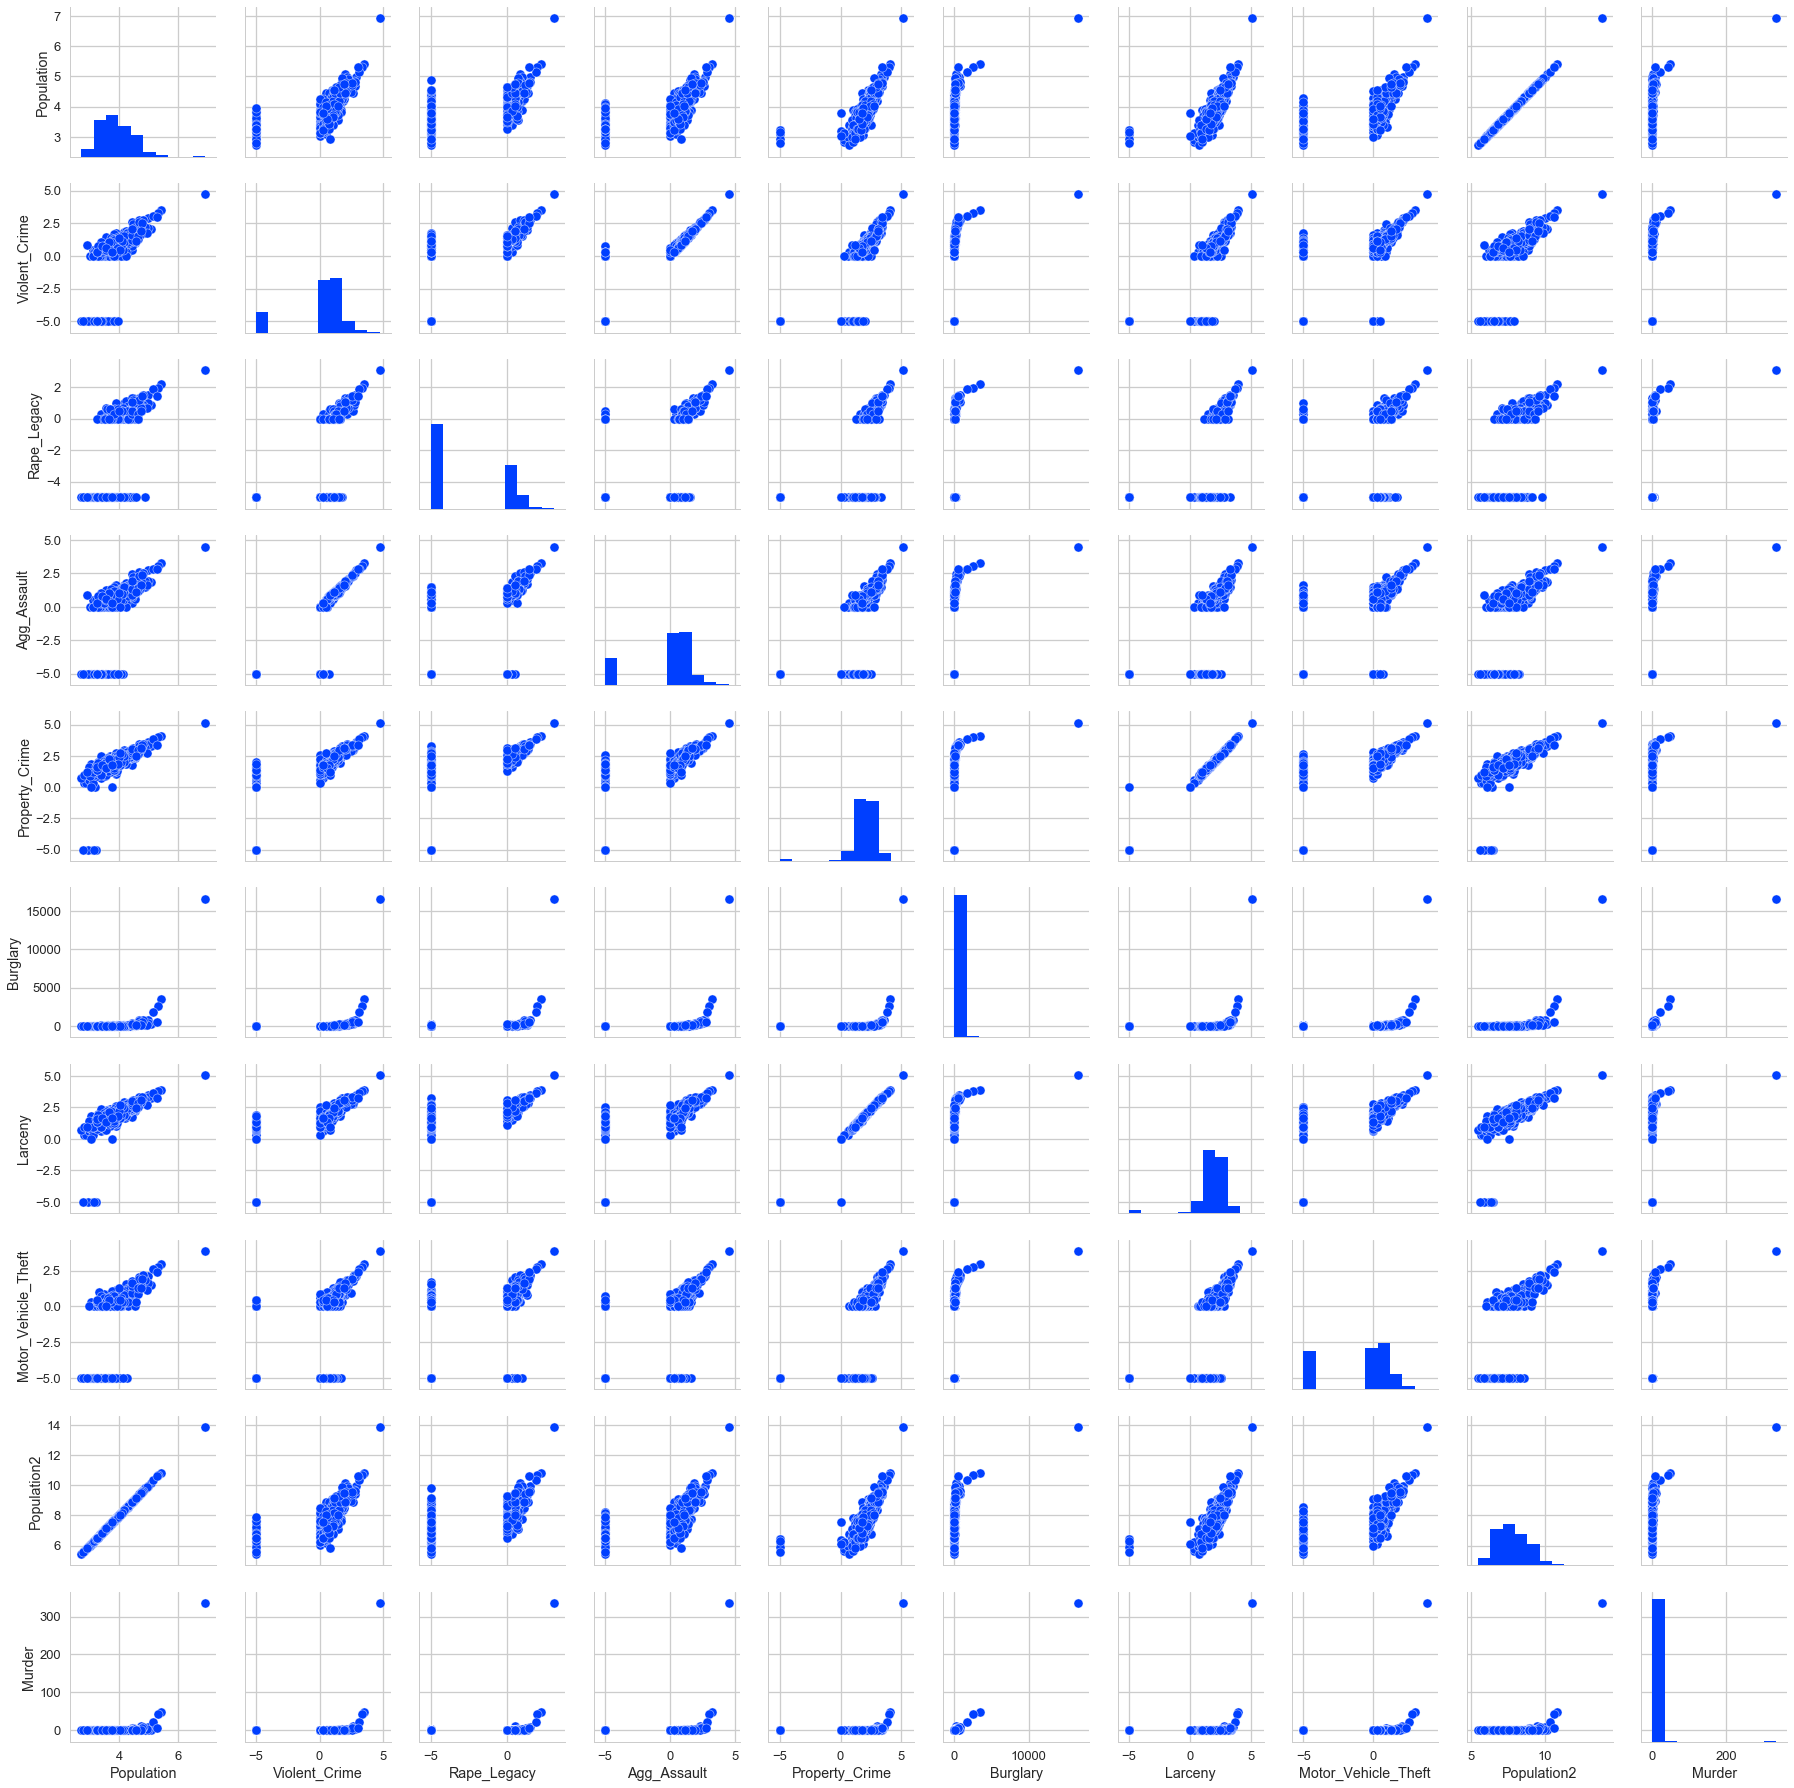

In [23]:
#plotting again
sns.pairplot(log_df);

In [36]:
# Instantiate and fit our model.
regr = linear_model.LinearRegression()
Y = log_df['Property_Crime']
X = log_df[['Population','Population2','Murder', 'Burglary']]
regr.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))


Coefficients: 
 [ 2.88837788e-01  5.77675576e-01 -2.84831069e-02  4.98569651e-04]

Intercept: 
 -3.675713641810693

R-squared:
0.45917375770741853


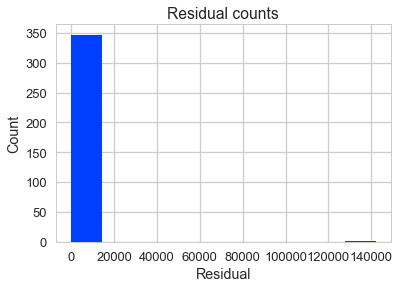

(0.05753529071807861, 4.5024437123570107e-38)

In [37]:
# Extract predicted values.
predicted = regr.predict(X).ravel()
actual = df['Property_Crime']

# Calculate the error, also called the residual.
residual = actual - predicted

# This looks a bit concerning.
plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

stats.shapiro(residual)

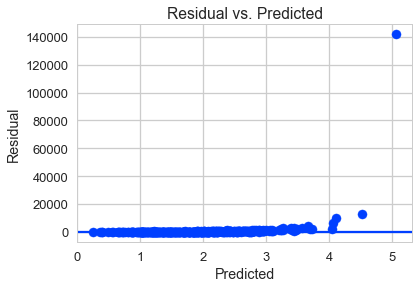

In [38]:
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

# looks like one outlier is way out there..

## Prepare data to model with multivariable regression according to the specification:

$$  Propertycrime = \alpha + Population + Population^2 + Murder + Robbery $$

 


### Convert Robbery and Murder to Categorical Variables

In [41]:
df.Murder = np.where(df.Murder >= 1, 1, 0)
df.Murder = df.Murder.astype('category')

df.Burglary = np.where(df.Burglary >= 1, 1, 0)
df.Burglary = df.Burglary.astype('category')

TypeError: Unordered Categoricals can only compare equality or not

### Create new column for  population squared

In [25]:
df['Population2'] = df.Population ** 2

In [26]:
df.sample(5)

,City,Population,Violent_Crime,Murder,Rape_Legacy,Robbery,Agg_Assault,Property_Crime,Burglary,Larceny,Motor_Vehicle_Theft,Arson,Population2
188,Marcellus Village,1792,0.000,0,0.000,0.000,0.000,13.000,1,11.000,0.000,0.000,3211264
334,Webster Town and Village,43777,21.000,0,2.000,3.000,16.000,469.000,1,361.000,7.000,nan,1916425729
95,Elmira Town,5948,0.000,0,0.000,0.000,0.000,1.000,0,1.000,0.000,0.000,35378704
270,Rhinebeck Village,2635,2.000,0,0.000,0.000,2.000,42.000,0,41.000,1.000,0.000,6943225
176,Lockport,20904,70.000,0,6.000,24.000,40.000,649.000,1,523.000,6.000,nan,436977216


## Build regression model to predict property crimes

In [27]:
# Instantiate and fit our model.
regr = linear_model.LinearRegression()
Y = df['Property_Crime']
X = df[['Population','Population2','Murder', 'Burglary']]
regr.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))


Coefficients: 
 [ 3.43252538e-02 -2.07182381e-09 -5.88995151e+00 -1.20890295e+02]

Intercept: 
 -45.541670294716596

R-squared:
0.9961061679670005


/usr/local/lib/python3.6/site-packages/sklearn/linear_model/base.py:509: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


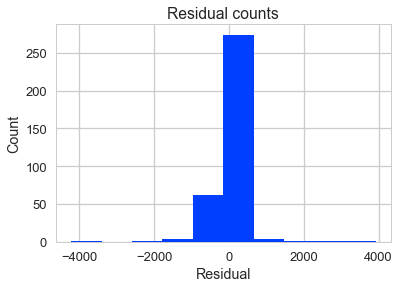

(0.597872257232666, 1.2013146917335796e-27)

In [28]:
# Extract predicted values.
predicted = regr.predict(X).ravel()
actual = df['Property_Crime']

# Calculate the error, also called the residual.
residual = actual - predicted

# This looks a bit concerning.
plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

stats.shapiro(residual)

/usr/local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/usr/local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


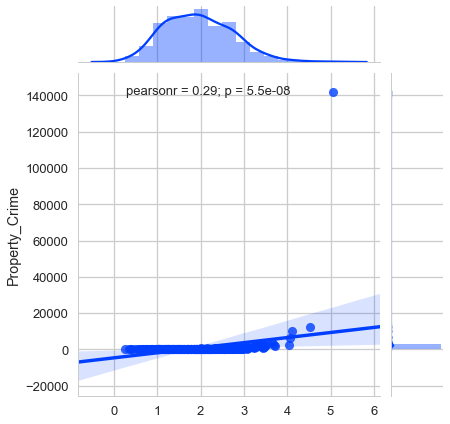

In [40]:
sns.jointplot(predicted, residual, kind='reg')

plt.show()

# looks like one outlier is way out there..

In [30]:
df.Property_Crime.describe()

count      348.000
mean       792.606
std       7659.725
min          0.000
25%         40.500
50%        112.500
75%        341.000
max     141971.000
Name: Property_Crime, dtype: float64

In [31]:
df.loc[df.Property_Crime >= 100000]

,City,Population,Violent_Crime,Murder,Rape_Legacy,Robbery,Agg_Assault,Property_Crime,Burglary,Larceny,Motor_Vehicle_Theft,Arson,Population2
216,New York,8396126,52384.000,1,1112.000,19170.000,31767.000,141971.000,1,117931.000,7434.000,nan,70494931807876


In [32]:
df2 = df[df.City != 'New York']

In [33]:
# Instantiate and fit our model.
regr = linear_model.LinearRegression()
Y = df2['Property_Crime']
X = df2[['Population','Population2','Murder', 'Burglary']]
regr.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))


Coefficients: 
 [1.43369237e-02 1.09341292e-07 2.06949154e+02 3.74334466e+01]

Intercept: 
 -14.60571622438448

R-squared:
0.8430848051485469


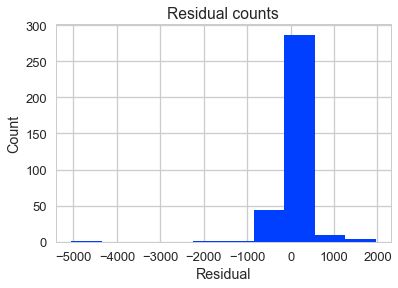

(0.5015647411346436, 4.507611199132098e-30)

In [34]:
# Extract predicted values.
predicted = regr.predict(X).ravel()
actual = df2['Property_Crime']

# Calculate the error, also called the residual.
residual = actual - predicted

# This looks a bit concerning.
plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

stats.shapiro(residual)

/usr/local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/usr/local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


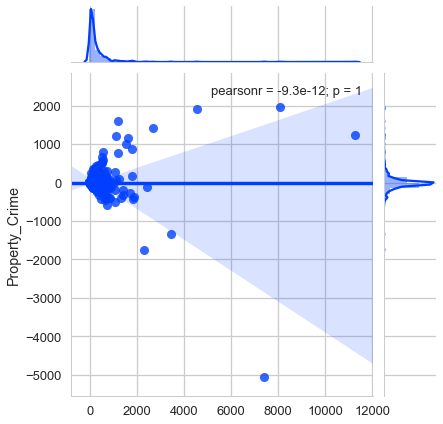

In [35]:
sns.jointplot(predicted, residual, kind='reg')
#plt.xlabel('Predicted')
#plt.ylabel('Residual')
#plt.axhline()
#plt.title('Residual vs. Predicted')
plt.show()

# not really sure if this is better?